In [78]:
%matplotlib inline
#import sys, traceback
import cv2
from PIL import Image
import zbarlight
#import numpy as np
import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use("TkAgg")
from plantcv import plantcv as pcv

pcv.params.debug = 'plot'                     # Plot debug images to the notebook
img_file = '/home/leonard/Documents/Uni/PhD/Phenotyping/2020-01_LAC_phenotyping/pipeline_test/dark.JPG'
ref_file = '/home/leonard/Documents/Uni/PhD/Phenotyping/2020-01_LAC_phenotyping/pipeline_test/good.JPG'
qr_file = '/home/leonard/Dropbox/DSC_0094.JPG'


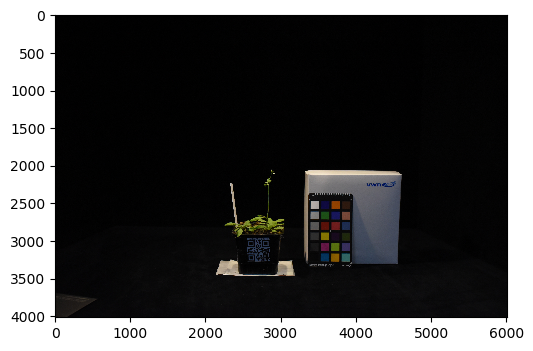

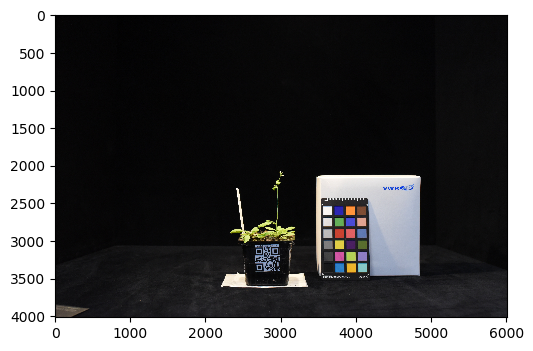

In [72]:
### Main pipeline

    # Read target image
    img, path, filename = pcv.readimage(filename = img_file, mode = "native")
    
    # Read ref image
    ref_img, ref_path, ref_filename = pcv.readimage(filename = ref_file, mode = "native")

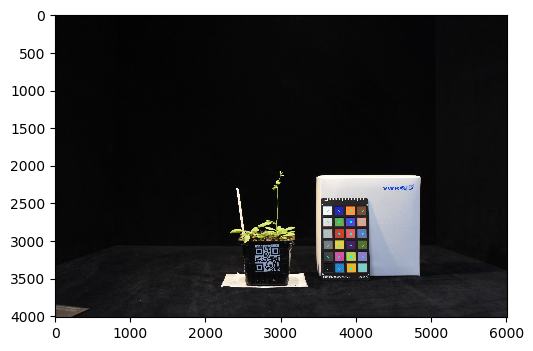

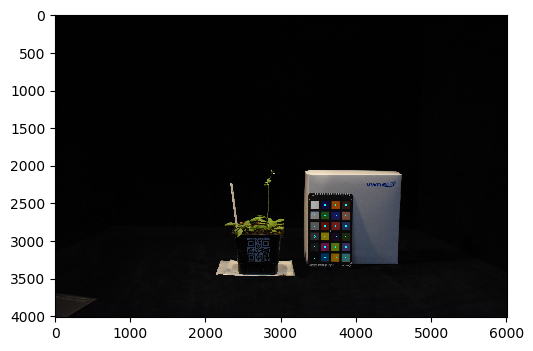

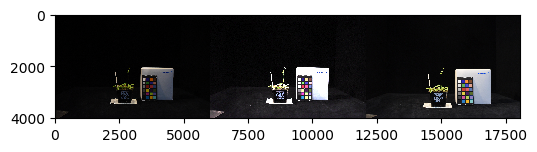

/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: 
The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: 
The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/scales/scale.py:89: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/utils.py:284: FutureWarning: Method .as_matrix will be 

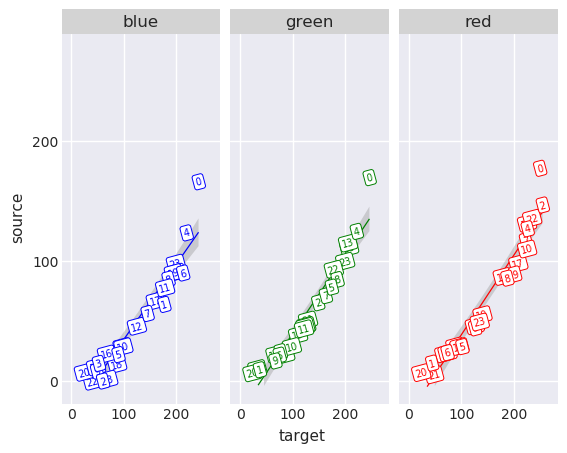

<ggplot: (-9223363275914823059)>


In [75]:
df, start, space = pcv.transform.find_color_card(rgb_img=ref_img)
target_mask = pcv.transform.create_color_card_mask(rgb_img=ref_img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6)

df, start, space = pcv.transform.find_color_card(rgb_img=img)
source_mask = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6)

output_directory = "."

target_matrix, source_matrix, transformation_matrix, corrected_img = pcv.transform.correct_color(ref_img, target_mask, img, source_mask, output_directory)
pcv.transform.quick_color_check(source_matrix = source_matrix, target_matrix = target_matrix, num_chips = 24)



In [83]:
with open(ref_file, 'rb') as image_file:
    image = Image.open(qr_file).convert('LA')
    image.load()
barcodes = zbarlight.scan_codes('qrcode', image)
print(barcodes)

None


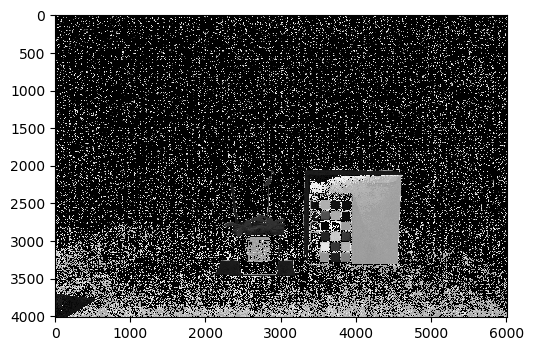

In [64]:
    # Convert RGB to HSV and extract the hue channel
    h = pcv.rgb2gray_hsv(img, "h")

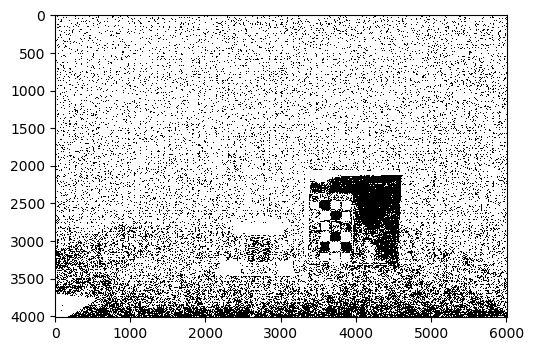

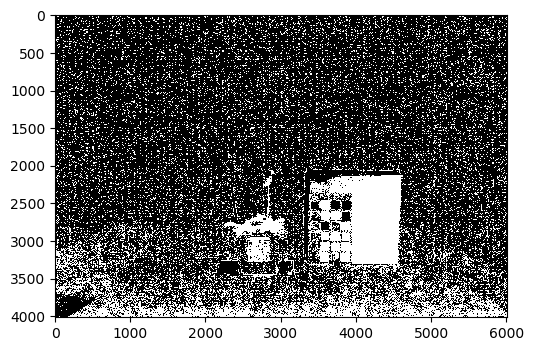

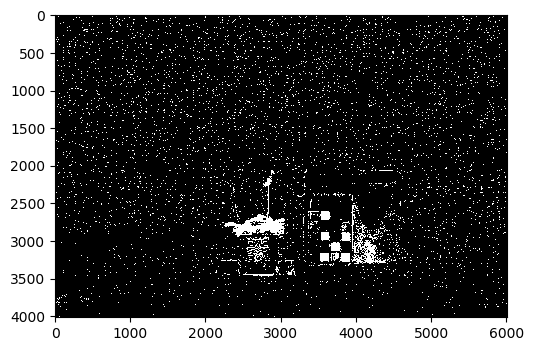

In [65]:
    # Threshold the hue image
    h_thresh1 = pcv.threshold.binary(h, 110, 255, "dark")
    h_thresh2 = pcv.threshold.binary(h, 20, 255, "light")
    h_thresh = pcv.logical_and(h_thresh1, h_thresh2)

In [ ]:
    # Convert RGB to HSV and extract the value channel
    h = pcv.rgb2gray_hsv(img, "v")

In [ ]:
    # Threshold the hue image
    v_thresh = pcv.threshold.binary(h, 20, 255, "light")

In [ ]:
    # Median Blur
    h_mblur = pcv.median_blur(h_thresh, 5)
    #h_cnt = pcv.median_blur(h_thresh, 5)

In [ ]:
    # Convert RGB to LAB and extract the Blue channel
    b = pcv.rgb2gray_lab(img, "a")

In [ ]:
    # Threshold the blue image
    b_thresh = pcv.threshold.binary(b, 120, 255, "dark")
    b_cnt = pcv.threshold.binary(b, 120, 255, "dark")

In [63]:
   # Join the thresholded saturation and blue-yellow images
    bh = pcv.logical_or(h_mblur, b_cnt)

NameError: name 'h_mblur' is not defined

In [62]:
    # Apply Mask (for VIS images, mask_color=white)
    masked = pcv.apply_mask(img, bh, "white")

NameError: name 'bh' is not defined

In [61]:

    # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(masked, "a")
    masked_b = pcv.rgb2gray_lab(masked, "b")

    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(masked_a, 115, 255, "dark")
    maskeda_thresh1 = pcv.threshold.binary(masked_a, 135, 255, "light")
    maskedb_thresh = pcv.threshold.binary(masked_b, 128, 255, "light")

    # Join the thresholded saturation and blue-yellow images (OR)
    ab1 = pcv.logical_or(maskeda_thresh, maskedb_thresh)
    ab = pcv.logical_or(maskeda_thresh1, ab1)

    # Fill small objects
    ab_fill = pcv.fill(ab, 200)

    # Apply mask (for VIS images, mask_color=white)
    masked2 = pcv.apply_mask(masked, ab_fill, "white")

NameError: name 'masked' is not defined

In [ ]:
# Identify objects
    id_objects, obj_hierarchy = pcv.find_objects(masked2, ab_fill)

In [ ]:
 # Define ROI
    roi1, roi_hierarchy= pcv.roi.rectangle(x=500, y=500, h=2500, w=3000, img=masked2)

In [ ]:

    # Decide which objects to keep
    roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi1, roi_hierarchy, id_objects, obj_hierarchy)

In [ ]:
# Object combine kept objects
    obj, mask = pcv.object_composition(img, roi_objects, hierarchy3)

In [ ]:
############### Analysis ################

outfile=False
if args.writeimg==True:
    outfile=args.outdir+"/"+filename

    # Find shape properties, output shape image (optional)
    shape_header, shape_data, shape_imgs = pcv.analyze_object(img, obj, mask)
    
    # analysis_images contains two images, the original image with shape data drawn on, and the mask
shape_info_img, shape_mask = shape_imgs
# Plot them out 
pcv.plot_image(shape_info_img)
pcv.plot_image(shape_mask)
pcv.print_image(shape_info_img, "outline_2.png")
pcv.print_image(shape_mask, "mask_2.png")


In [ ]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   bins - Number of color bins (0-256)
#   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
#                    This is the data to be printed to the SVG histogram file  
color_header, color_data, color_histogram = pcv.analyze_color(img, kept_mask, 256, 'all')

# color_histogram is a list containing the histogram image, store it 
color_hist = color_histogram[0]

In [ ]:
# The color_histogram image is a plotnine ggplot; we can plot it to the screen without pcv.plot_image
pcv.plot_image(color_hist)

In [ ]:
# Divide plant object into twenty equidistant bins and assign pseudolandmark points based upon their 
# actual (not scaled) position. Once this data is scaled this approach may provide some information 
# regarding shape independent of size.

top_x, bottom_x, center_v_x = pcv.x_axis_pseudolandmarks(obj, mask, img)

In [ ]:
top_y, bottom_y, center_v_y = pcv.y_axis_pseudolandmarks(obj, mask, img)

In [ ]:
# Write shape and color data to results file
# Result file will go to the notebooks folder! 
result = open(args.result,"a")
result.write('\t'.join(map(str,shape_header)))
result.write("\n")
result.write('\t'.join(map(str,shape_data)))
result.write("\n")
result.write('\t'.join(map(str,color_header)))
result.write("\n")
result.write('\t'.join(map(str,color_data)))
result.write("\n")
result.close()